In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

ibmqfactory.load_account:WARNING:2023-08-03 13:29:34,204: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n)])


def effective_hem(size, J):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        hem[i, i] = h(size, J, Z)
    return hem

In [9]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = 10
shots = np.arange(10, 2000, 100)
delay = np.linspace(0, 2 * np.pi, measurements)
repetitions = 100
for n in range(2, 6):  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(n)]
            delay_list = []
            for t in delay:
                delay_list.append(RamseyExperiment(n, t, s // measurements, J=J))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)

        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots


    exp.append(shot_list)


Failed to converge. Skipping...
Failed to converge. Skipping...
Failed to converge. Skipping...
Failed to converge. Skipping...
Failed to converge. Skipping...
Failed to converge. Skipping...
Failed to converge. Skipping...


20
20
20


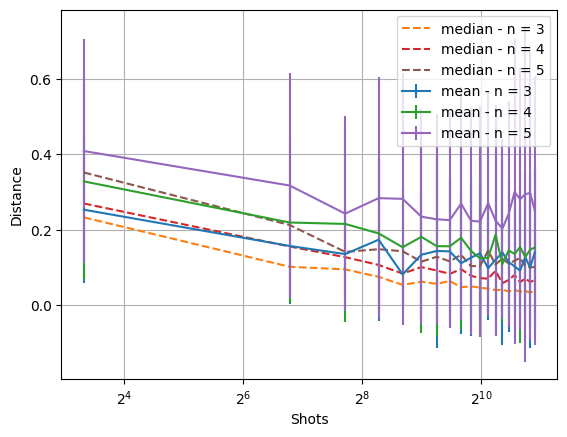

In [10]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    print(len(dist["mean"]))
    plt.errorbar(shots, dist["mean"],yerr=dist["std"], linestyle='-',  label=f'mean - n = {str(i + 2)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - n = {str(i + 2)}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points

In [11]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = np.arange(5,40,10)

shots = np.arange(10, 2000, 100)
repetitions = 50
for n in measurements:  #qubits
    shot_list = {}
    for s in shots:
        rep_list = {}
        median_dist_for_shots = []
        mean_dist_for_shots = []
        std_dist_for_shots = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(n)]
            delay_list = []
            delay = np.linspace(0, 2 * np.pi, n)
            for t in delay:
                delay_list.append(RamseyExperiment(4, t, s // measurements, J=J))
            ramseyBatch = RamseyBatch(delay_list)
            rep_list.append(ramseyBatch)
        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots


    exp.append(shot_list)



TypeError: (): incompatible function arguments. The following argument types are supported:
    1. (self: qiskit_aer.backends.controller_wrappers.AerConfig, arg0: int) -> None

Invoked with: <qiskit_aer.backends.controller_wrappers.AerConfig object at 0x000001A221CAA5F0>, array([2, 0, 0, 0], dtype=int32)

In [ ]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    plt.errorbar(shots, dist["mean"],yerr=dist["std"], linestyle='-',  label=f'mean - measurement points = {str(i)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - measurement points = {str(i)}')
plt.xscale('log', base=2)
plt.legend()

[1.0, 1.0, 1.0]
[0.99627599 1.0018095  1.00180396]
1.0


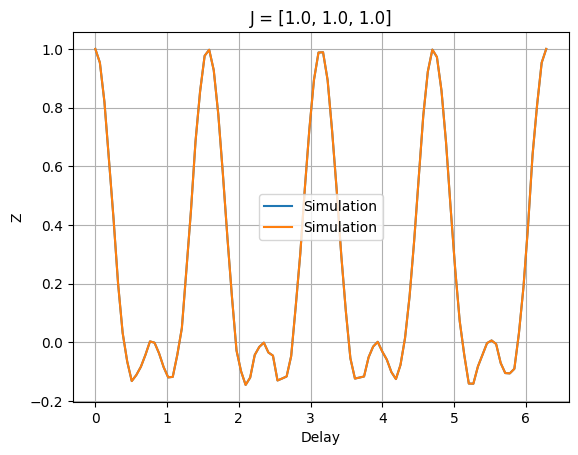

In [4]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch
delay_list = []
exp = []
measurements = 100
delay = np.linspace(0,2*np.pi,100)
J = [random.gauss(1, 0) for _ in range(3)]
for t in delay:
    delay_list.append(RamseyExperiment(3, t, 6000, J=J))
ramseyBatch = RamseyBatch(delay_list)

print(J)
print(ramseyBatch.J_fit)
print(ramseyBatch.RamseyExperiments[0].z)
#print(ramseyBatch.Z)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
plt.title(f'J = {J}')
plt.plot(delay,ramseyBatch.Z, label = 'Simulation')

plt.plot(delay,[rexp.z for rexp in delay_list], label = 'Simulation')
plt.legend()